# Clean and Explore SF Site Inventory

In [49]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import contextily as ctx
import os

In [18]:
pd.set_option('max_columns', 50)

Load all opportunity sites across the Bay Area from 2007 to 2023.

In [26]:
df = gpd.read_file(
    './data/raw_data/housing_sites/xn--Bay_Area_Housing_Opportunity_Sites_Inventory__20072023_-it38a.shp'
)
df.shape

(42133, 35)

## Cleaning

#### Filter for SF's 5th RHNA cycle

In [20]:
sf_sites = df.query('jurisdict == "San Francisco" and rhnacyc == "RHNA5"').copy()
sf_sites.fillna(value=np.nan, inplace=True)
sf_sites['allowden'] = sf_sites['allowden'].astype(float)
sf_sites['relcapcty'] = sf_sites['relcapcty'].astype(float)

#### Drop the 17 uninformative columns (i.e. constant or all NaNs)

In [21]:
sf_sites.shape

(6158, 35)

In [22]:
is_constant = ((sf_sites == sf_sites.iloc[0]).all())
constant_cols = is_constant[is_constant].index.values
constant_cols

array(['rhnacyc', 'rhnayrs', 'county', 'jurisdict', 'currunits',
       'allowlow', 'num_vl', 'num_l', 'num_m', 'num_am'], dtype=object)

In [23]:
sf_sites.drop(constant_cols, axis=1, inplace=True)

In [24]:
sf_sites.dropna(how='all', axis=1, inplace=True)

In [25]:
sf_sites.shape

(6158, 16)

## Exploring Dataset

#### Deciphering these variable names

**apn** is an identifier used by tax assessors for parcels, i.e. an 'assessor's parcel number.' The format is 'block/lot', e.g. an apn of '3905/002A' means lot 002A on block 3905. 

It's unclear how **locapn** is different. Apn and locapn are identical across all observations save for this one parcel:

In [10]:
sf_sites[sf_sites.apn != sf_sites.locapn]

objectid        apn    locapn  genplan   zoning  gacres  locacres  \
30766     72900  3905/002A  3905/002  Mission  PDR-1-G   0.218  0.669399   

       allowden  allowhigh  relcapcty       sitetype pdaparcel    existuse  \
30766       0.0          0        0.0  Underutilized         Y  Industrial   

         Shape__Are  Shape__Len  \
30766  9.026871e-08    0.002165   

                                                geometry  
30766  POLYGON ((-122.40885 37.76880, -122.40896 37.7...

The colummns **genplan** and **zoning** are self-explanatory. 

I think **gacres** is the city's reported acreage, whereas **locacres** is the acreage calculated from the coordinates. **locacres** tends to be more precise

In [12]:
sf_sites[['locacres', 'gacres']].head()

locacres  gacres
17865  0.045914   0.046
18061  0.045914   0.046
18134  0.183346   0.183
18210  0.054911   0.055
18233  0.034435   0.034

When I try to I calculate the acreage from the coordinates using a semi-arbitrary projection, it's quite close to **locacres** in the above table:

In [13]:
m_to_km = 1 / 10**6
km_to_acre = 247.105
sf_sites.geometry.head().to_crs(epsg=5070).area * m_to_km * km_to_acre

17865    0.045920
18061    0.045920
18134    0.183372
18210    0.054919
18233    0.034440
dtype: float64

**allowden** is the parcel's acreage multiplied by the zoning's maximum density per acre. And **allowhigh** is just **allowden** rounded to the nearest unit. Both indicate the allowable density in 2015, at the start of the Housing Element. For 1527 observations, **relcapcty** exceeds the allowable density, which indicates that SF intended to rezone those parcel to achieve a higher capacity, which state law permits.

In [15]:
sf_sites[sf_sites.allowden.fillna(0)>sf_sites.allowhigh].head()

objectid        apn     locapn       genplan zoning  gacres  locacres  \
23440     65574   0324/005   0324/005      Downtown   RC-4   0.118  0.118432   
23458     65592   0323/010   0323/010      Downtown   RC-4   0.102  0.101929   
23481     65615  2082/001K  2082/001K  Outer Sunset   NC-1   0.053  0.053375   
24646     66780   0024/011   0024/011     Northeast   NC-1   0.115  0.114784   
24649     66783   0027/008   0027/008     Northeast   RH-3   0.079  0.079055   

         allowden  allowhigh  relcapcty       sitetype pdaparcel     existuse  \
23440  194.204454        194       23.0         Vacant         Y       Vacant   
23458  186.405090        186       19.0  Underutilized         Y   Office Bld   
23481   37.470904         37        2.0  Underutilized       NaN   Commercial   
24646   52.272029         52        6.0  Underutilized         Y  Comm Garage   
24649   25.298964         25        2.0  Underutilized         Y     Dwelling   

         Shape__Are  Shape__Len  \
23440  4.902768e-08    0.001020   
23458  4.219510e-08    0.000919   
23481  2.208617e-08    0.000684   
24646  4.753110e-08    0.000898   
24649  3.273544e-08    0.000934   

                                                geometry  
23440  POLYGON ((-122.41176 37.78510, -122.41189 37.7...  
23458  POLYGON ((-122.41348 37.78488, -122.41360 37.7...  
23481  POLYGON ((-122.50481 37.75261, -122.50486 37.7...  
24646  POLYGON ((-122.41981 37.80589, -122.41998 37.8...  
24649  POLYGON ((-122.41928 37.80525, -122.41924 37.8...

In [16]:
# relcapcty exceeds allowhigh on 1527 parcels
sum(sf_sites.relcapcty > sf_sites.allowhigh)

1527

In [17]:
sf_sites.columns

Index(['objectid', 'apn', 'locapn', 'genplan', 'zoning', 'gacres', 'locacres',
       'allowden', 'allowhigh', 'relcapcty', 'sitetype', 'pdaparcel',
       'existuse', 'Shape__Are', 'Shape__Len', 'geometry'],
      dtype='object')

### Visualizations

In [32]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

to_plot = sf_sites.to_crs(epsg=3857)
to_plot['relcapcty_ln'] = np.log(to_plot.relcapcty + 1)

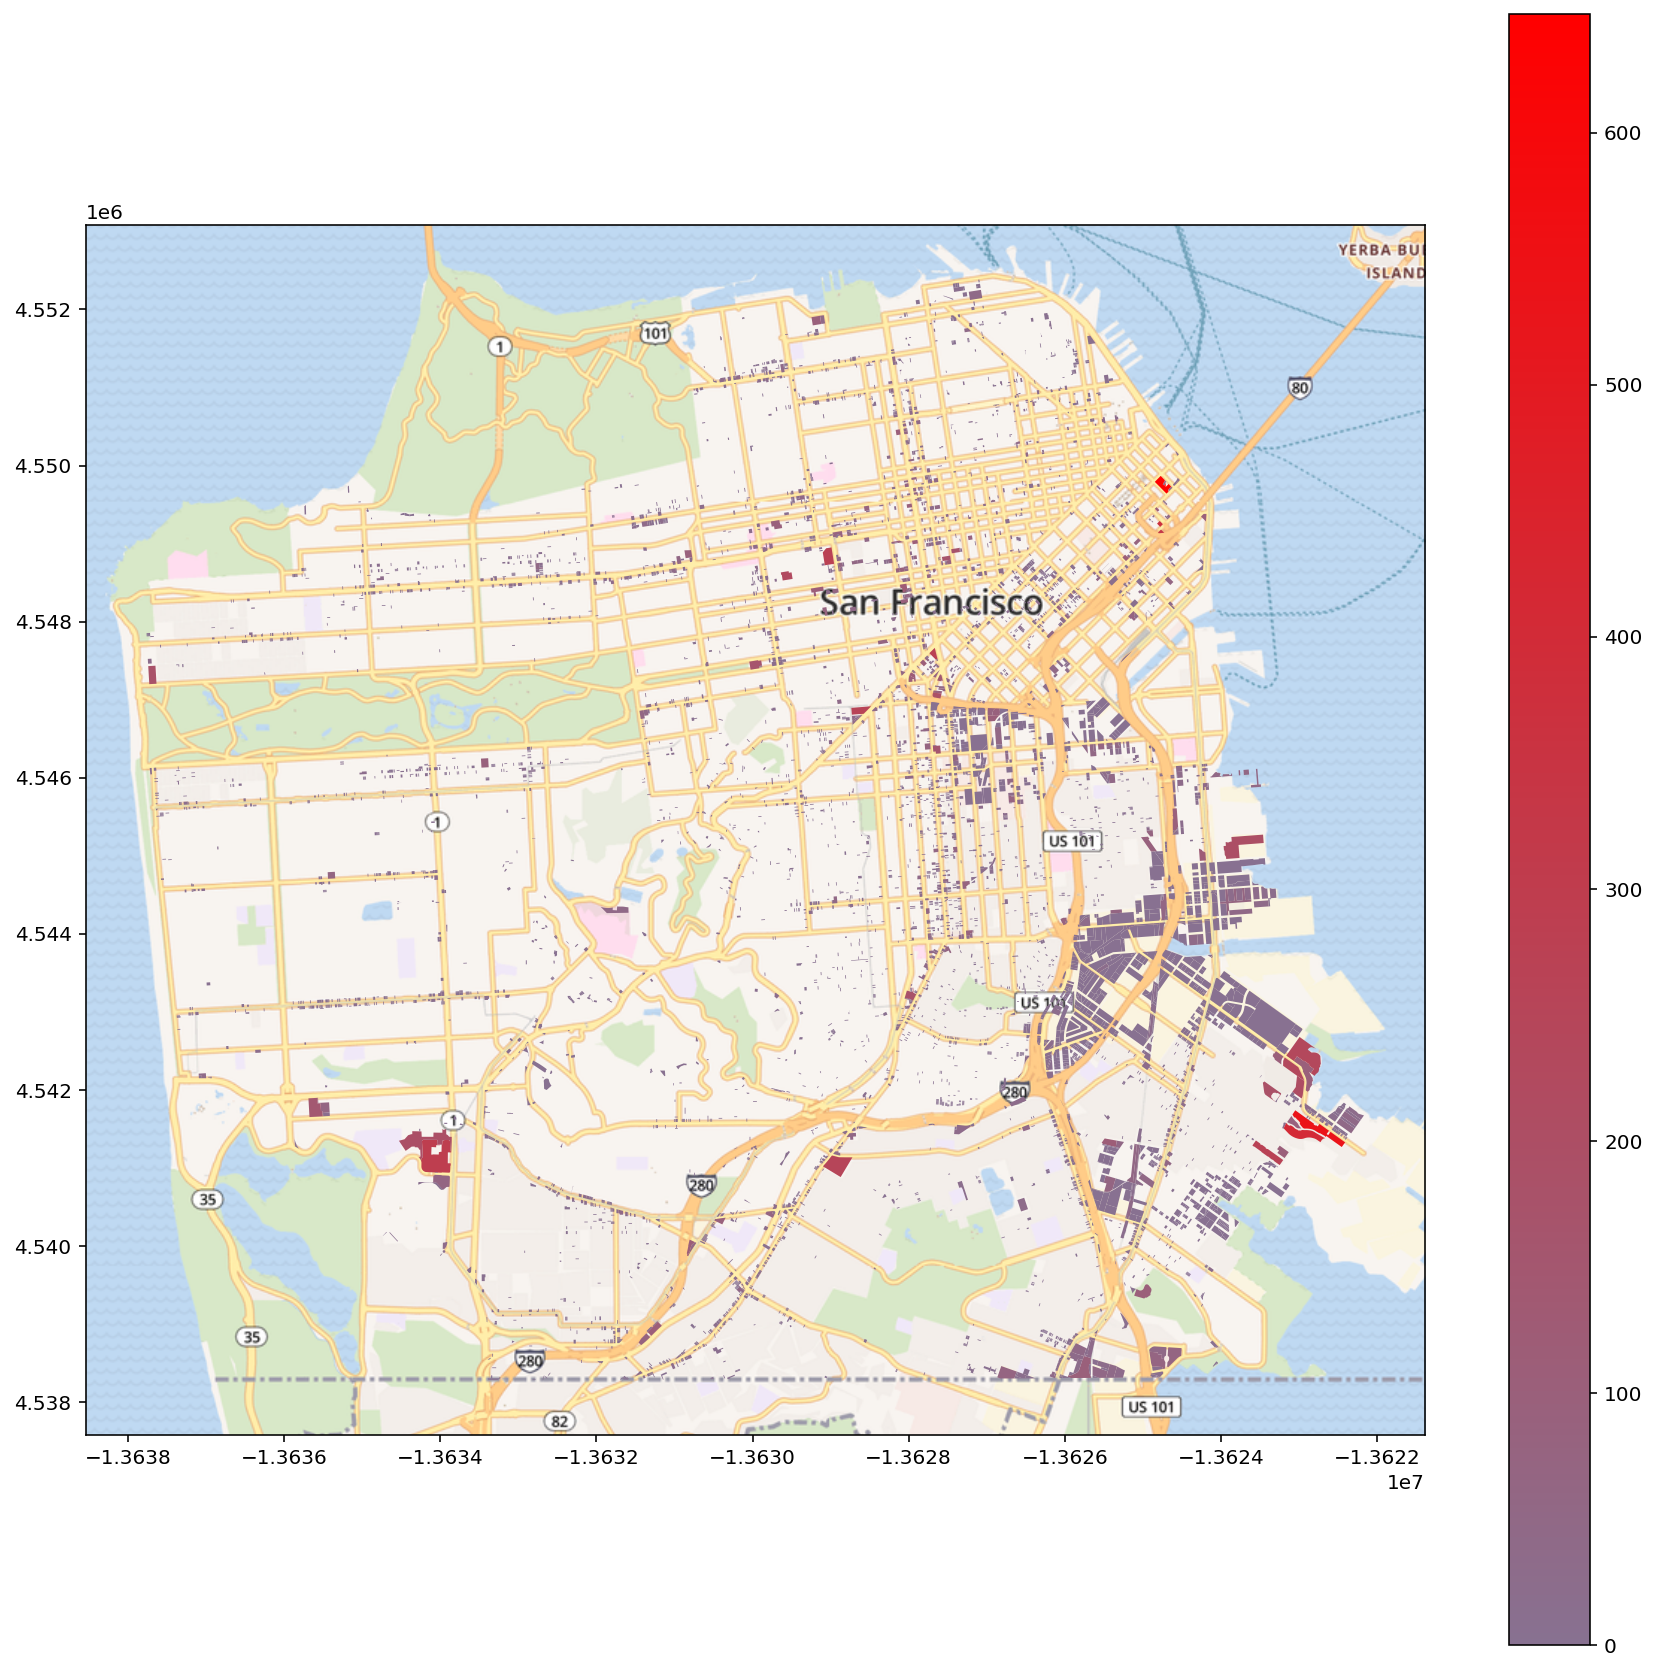

In [43]:
fig, ax = plt.subplots(figsize=(15, 15))
cmap = LinearSegmentedColormap.from_list('mycmap', ['xkcd:greyish purple', 'red'])

to_plot.plot(ax=ax, column='relcapcty', legend=True, cmap=cmap)

ctx.add_basemap(
    ax, 
    source='https://tiles.stadiamaps.com/tiles/osm_bright/{z}/{x}/{y}{r}.png?api_key=c50d11b9-261a-4916-b968-fe8854621c78'
)

### Log scale

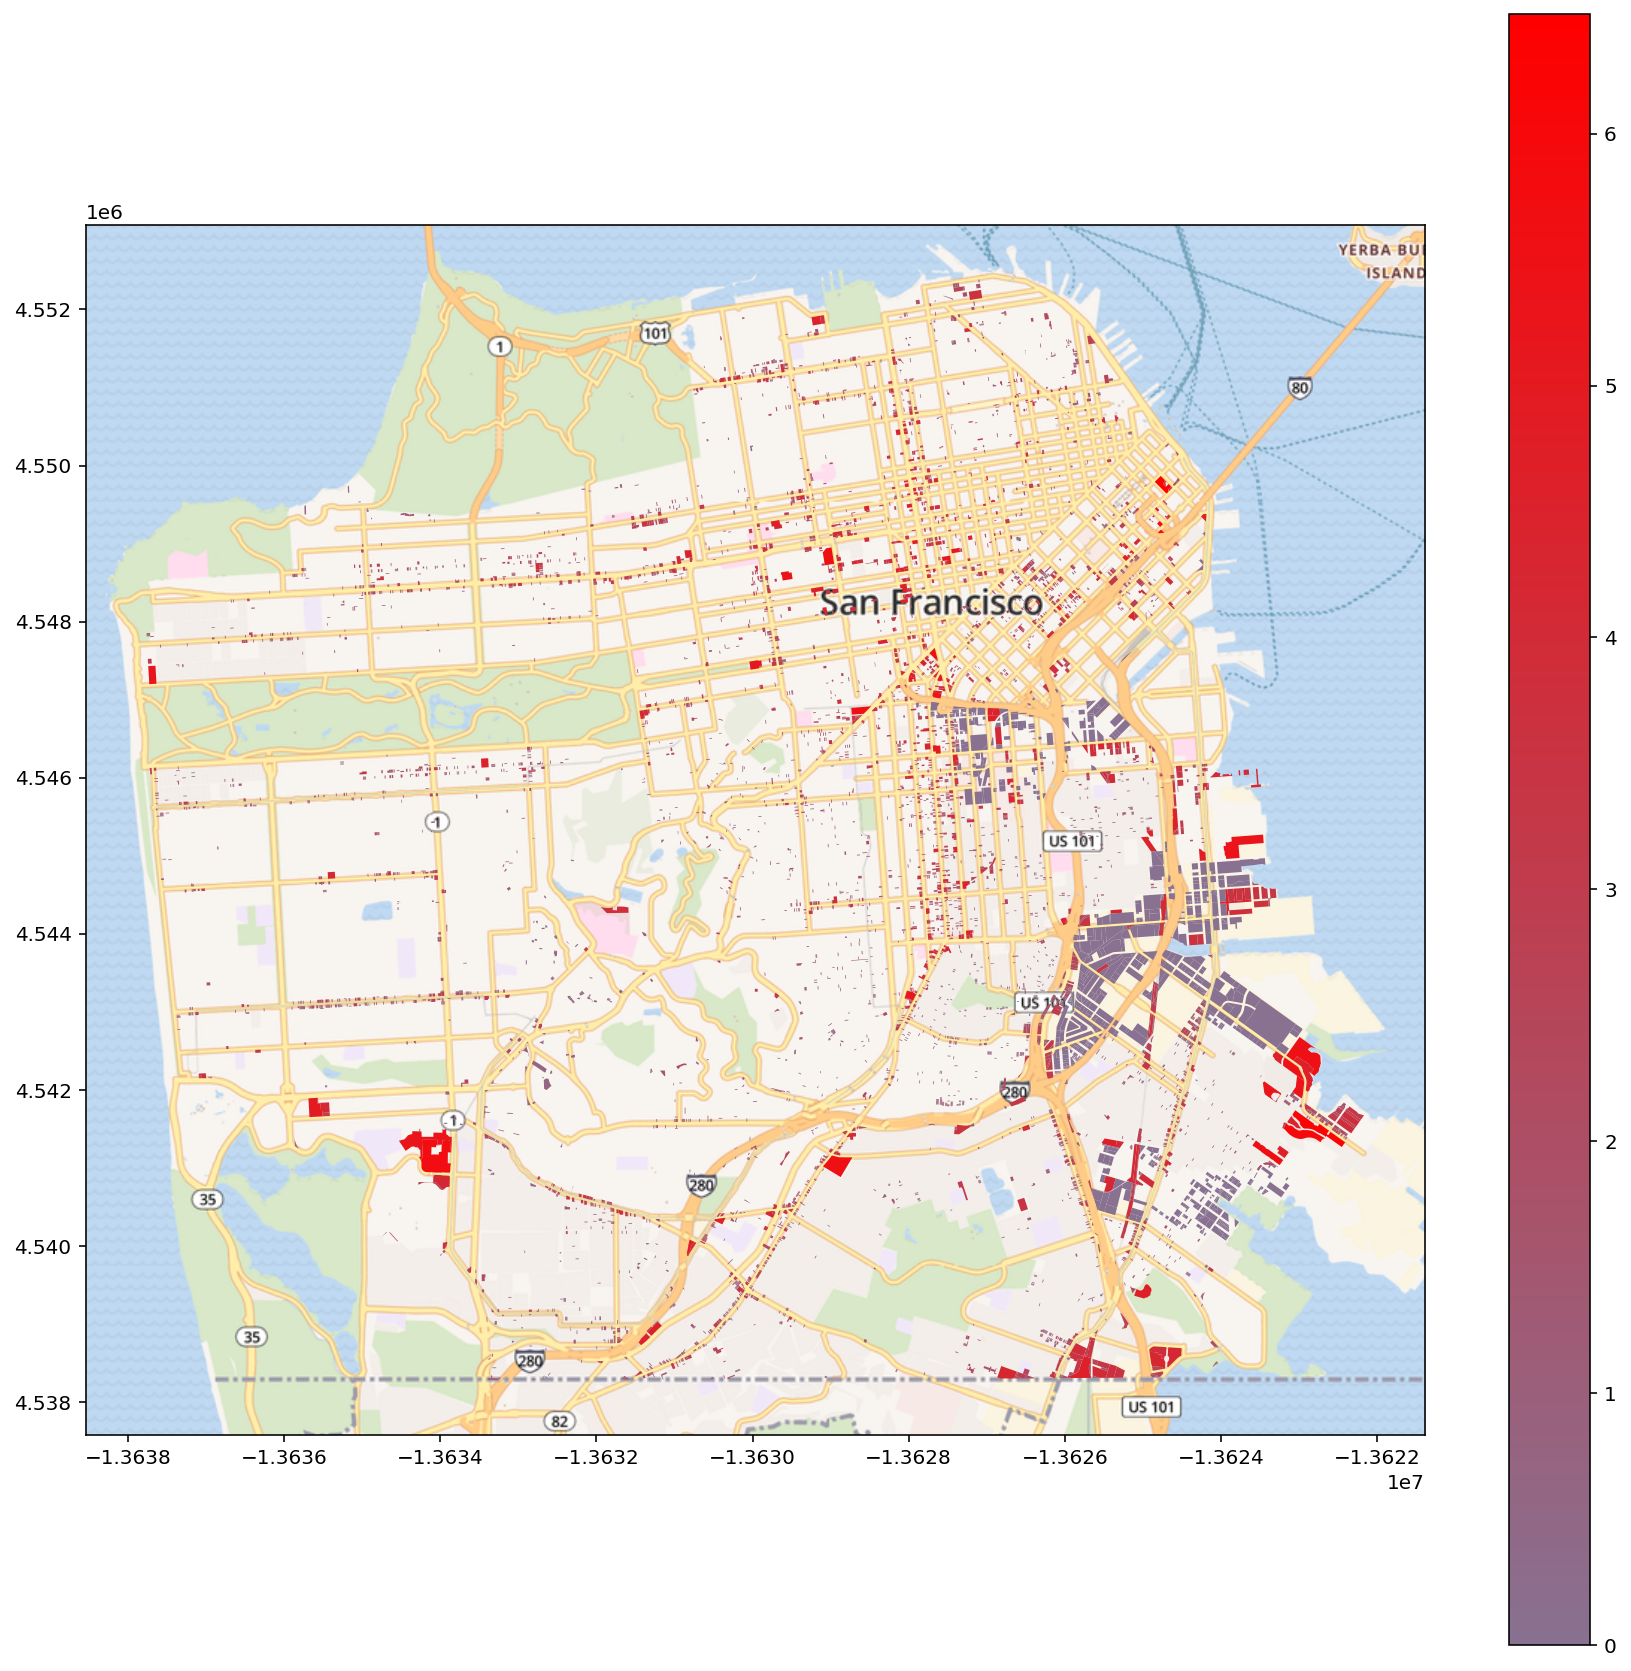

In [45]:
fig, ax = plt.subplots(figsize=(15, 15))

to_plot.plot(ax=ax, column='relcapcty_ln', legend=True, cmap=cmap)

ctx.add_basemap(
    ax, 
    source='https://tiles.stadiamaps.com/tiles/osm_bright/{z}/{x}/{y}{r}.png?api_key=c50d11b9-261a-4916-b968-fe8854621c78'
)

In [46]:
sf_sites.columns

Index(['objectid', 'apn', 'locapn', 'genplan', 'zoning', 'gacres', 'locacres',
       'allowden', 'allowhigh', 'relcapcty', 'sitetype', 'pdaparcel',
       'existuse', 'Shape__Are', 'Shape__Len', 'geometry'],
      dtype='object')

In [53]:
if not os.path.isdir('./clean_data'):
    os.mkdir('./clean_data')
    
sf_sites.to_csv('./clean_data/sf_sites.csv', index=False)